This runs DeepExplainer with the model trained on simualted genomic data from the DeepLIFT repo (https://github.com/kundajelab/deeplift/blob/master/examples/genomics/genomics_simulation.ipynb), using a dynamic reference (i.e. the reference varies depending on the input sequence; in this case, the reference is a collection of dinucleotide-shuffled versions of the input sequence)

In [1]:
%matplotlib inline

Pull in the relevant data

In [2]:
! [[ ! -f sequences.simdata.gz ]] && wget https://raw.githubusercontent.com/AvantiShri/model_storage/db919b12f750e5844402153233249bb3d24e9e9a/deeplift/genomics/sequences.simdata.gz
! [[ ! -f keras2_conv1d_record_5_model_PQzyq_modelJson.json ]] && wget https://raw.githubusercontent.com/AvantiShri/model_storage/b6e1d69/deeplift/genomics/keras2_conv1d_record_5_model_PQzyq_modelJson.json
! [[ ! -f keras2_conv1d_record_5_model_PQzyq_modelWeights.h5 ]] && wget https://raw.githubusercontent.com/AvantiShri/model_storage/b6e1d69/deeplift/genomics/keras2_conv1d_record_5_model_PQzyq_modelWeights.h5
! [[ ! -f test.txt.gz ]] && wget https://raw.githubusercontent.com/AvantiShri/model_storage/9aadb769735c60eb90f7d3d896632ac749a1bdd2/deeplift/genomics/test.txt.gz

--2018-11-10 21:05:17--  https://raw.githubusercontent.com/AvantiShri/model_storage/db919b12f750e5844402153233249bb3d24e9e9a/deeplift/genomics/sequences.simdata.gz
Resolving raw.githubusercontent.com... 151.101.200.133
Connecting to raw.githubusercontent.com|151.101.200.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 629502 (615K) [application/octet-stream]
Saving to: 'sequences.simdata.gz'

100%[======================================>] 629,502     3.10MB/s   in 0.2s   

2018-11-10 21:05:18 (3.10 MB/s) - 'sequences.simdata.gz' saved [629502/629502]

--2018-11-10 21:05:18--  https://raw.githubusercontent.com/AvantiShri/model_storage/b6e1d69/deeplift/genomics/keras2_conv1d_record_5_model_PQzyq_modelJson.json
Resolving raw.githubusercontent.com... 151.101.200.133
Connecting to raw.githubusercontent.com|151.101.200.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3010 (2.9K) [text/plain]
Saving to: 'keras2_conv1d_record_5_model_PQz

Load the data

In [3]:
! pip install simdna

You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
import gzip

import simdna.synthetic as synthetic

data_filename = "sequences.simdata.gz"

# read in the data in the testing set
test_ids_fh = gzip.open("test.txt.gz", "rb")
ids_to_load = [x.decode("utf-8").rstrip("\n") for x in test_ids_fh]
data = synthetic.read_simdata_file(data_filename, ids_to_load=ids_to_load)

In [5]:
import numpy as np


# this is set up for 1d convolutions where examples
# have dimensions (len, num_channels)
# the channel axis is the axis for one-hot encoding.
def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence), 4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(
        zeros_array=to_return, sequence=sequence, one_hot_axis=1
    )
    return to_return


def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis == 0 or one_hot_axis == 1
    if one_hot_axis == 0:
        assert zeros_array.shape[1] == len(sequence)
    elif one_hot_axis == 1:
        assert zeros_array.shape[0] == len(sequence)
    # will mutate zeros_array
    for i, char in enumerate(sequence):
        if char == "A" or char == "a":
            char_idx = 0
        elif char == "C" or char == "c":
            char_idx = 1
        elif char == "G" or char == "g":
            char_idx = 2
        elif char == "T" or char == "t":
            char_idx = 3
        elif char == "N" or char == "n":
            continue  # leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: " + str(char))
        if one_hot_axis == 0:
            zeros_array[char_idx, i] = 1
        elif one_hot_axis == 1:
            zeros_array[i, char_idx] = 1


onehot_data = np.array(
    [one_hot_encode_along_channel_axis(seq) for seq in data.sequences]
)

Load the model

In [6]:
from keras.models import model_from_json

# load the keras model
keras_model_weights = "keras2_conv1d_record_5_model_PQzyq_modelWeights.h5"
keras_model_json = "keras2_conv1d_record_5_model_PQzyq_modelJson.json"

keras_model = model_from_json(open(keras_model_json).read())
keras_model.load_weights(keras_model_weights)

Couldn't import dot_parser, loading of dot files will not be possible.


Using TensorFlow backend.


Install the deeplift package for the dinucleotide shuffling and visualzation code

In [7]:
!pip install deeplift

You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### Compute importance scores

Define the function that generates the reference, in this case by performing a dinucleotide shuffle of the given input sequence

In [8]:
from deeplift.dinuc_shuffle import (
    prepare_edges,
    shuffle_edges,
    traverse_edges,
)


def onehot_dinuc_shuffle(s):
    s = np.squeeze(s)
    argmax_vals = "".join([str(x) for x in np.argmax(s, axis=-1)])
    shuffled_argmax_vals = [
        int(x)
        for x in traverse_edges(argmax_vals, shuffle_edges(prepare_edges(argmax_vals)))
    ]
    to_return = np.zeros_like(s)
    to_return[list(range(len(s))), shuffled_argmax_vals] = 1
    return to_return


def shuffle_several_times(s):
    return np.array([onehot_dinuc_shuffle(s) for i in range(100)])

Run DeepExplainer with the dynamic reference function

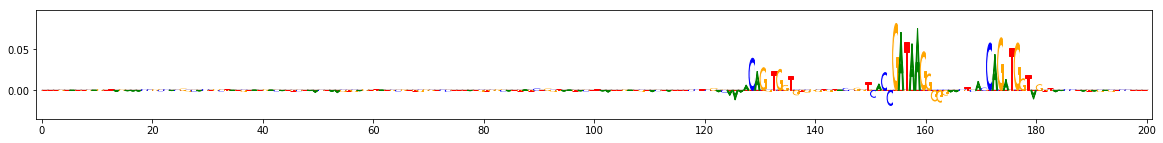

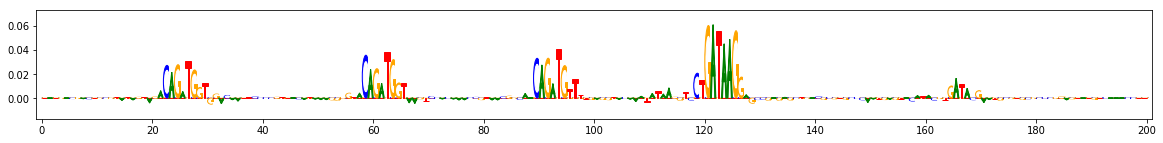

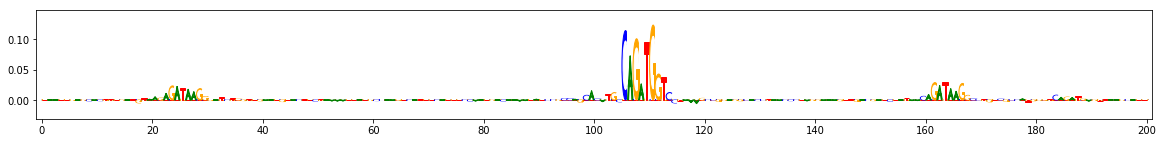

In [9]:
import numpy as np
from deeplift.visualization import viz_sequence

import shap
import shap.explainers.deep.deep_tf

np.random.seed(1)

seqs_to_explain = onehot_data[[0, 3, 9]]  # these three are positive for task 0
dinuc_shuff_explainer = shap.DeepExplainer(
    (keras_model.input, keras_model.output[:, 0]), shuffle_several_times
)
raw_shap_explanations = dinuc_shuff_explainer.shap_values(seqs_to_explain)

# project the importance at each position onto the base that's actually present
dinuc_shuff_explanations = (
    np.sum(raw_shap_explanations, axis=-1)[:, :, None] * seqs_to_explain
)
for dinuc_shuff_explanation in dinuc_shuff_explanations:
    viz_sequence.plot_weights(dinuc_shuff_explanation, subticks_frequency=20)